In [1]:
import os
import sys
import pandas as pd 
import random
from collections import Counter
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection as fdr
from collections import Counter
sys.path.append('../src')
import abd_profile
import copy


In [2]:
# n: repeat time
# k: sample number

def simulate(se_list, phenotype, n=100, k=None):
    se_dict = {}
    pvalues = []
    for i in range(n):
        se_dict[i] = {}
        random.shuffle(se_list)
        if not k:
            groups = list(set(phenotype))
            num_dict = Counter(phenotype)
            # print(se_list)
            # print(phenotype, num_dict)
            sampled_list1 = se_list[: num_dict[groups[0]]]
            sampled_list2 = se_list[num_dict[groups[0]]:]
            se_dict[i][groups[0]] = copy.deepcopy(sampled_list1)
            se_dict[i][groups[1]] = copy.deepcopy(sampled_list2)
        else:
            sampled_list1 = se_list[: k]
            sampled_list1 = se_list[k:]
            se_dict[i]['0'] = copy.deepcopy(sampled_list1)
            se_dict[i]['1'] = copy.deepcopy(sampled_list2)
        p_value = mannwhitneyu(sampled_list1, sampled_list2)[1]
        pvalues.append(p_value)
    p_adj = fdr(pvalues)[1]
    return p_adj, se_dict

def pheno_shuffle_simu(se_df, phenotype, n=100, k=None):
    pvalues = {}
    cluster_se_dict = {}
    for col in se_df.columns:
        se_list = se_df[col]
        p_adj, se_dict = simulate(se_list, phenotype, n, k)
        cluster_se_dict[col] = copy.deepcopy(se_dict)
        pvalues[col] = p_adj
    return pvalues, cluster_se_dict

def pheno_shuffle_summary(pvalues, alpha=0.05):
    for key, value in pvalues.items():
        p_valid = value < alpha
        valid_num = sum(p_valid)
        print(f"{key}: Valid number: {valid_num}, portion: {valid_num/len(pvalues)}")

def output_result(pvalues, cohort_se_dict, outdir):
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outpath = os.path.join(outdir, 'pvalues.tsv')
    with open(outpath, 'w') as f:
        for key, value in pvalues.items():
            f.write('{}\t{}\n'.format(key, '\t'.join([str(v) for v in value])))
    for cluster, value in cohort_se_dict.items():
        for i, se_dict in value.items():
            outpath = os.path.join(outdir, 'se_{}_{}.tsv'.format(cluster, i))
            with open(outpath, 'w') as f:
                for key, value in se_dict.items():
                        f.write('{}\t{}\n'.format(key, '\t'.join([str(v) for v in value])))

def read_cohort(indir, sedir):
    # Load the dataset
    abd_path = os.path.join(indir, 'abd.tsv')
    metadata_path = os.path.join(indir, 'metadata.tsv')
    # first process data from gutmeta
    raw_profile = abd_profile.input_profile(abd_path, transfer=True)
    metadata = pd.read_csv(metadata_path, sep='\t', header=0)
    selected_raw_profile = raw_profile.loc[list(metadata['sample_id']), :]
    selected_raw_profile = abd_profile.rename_s_level(selected_raw_profile)
    crc_profile = abd_profile.clean(selected_raw_profile)

    pheno_list = {}
    for i in range(metadata.shape[0]):
        pheno = metadata.loc[i, 'disease']
        if pheno not in pheno_list.keys():
            pheno_list[pheno] = []
        if metadata.loc[i, 'sample_id'] in list(crc_profile.index):
            pheno_list[pheno].append(metadata.loc[i, 'sample_id'])

    se_dict = {}
    for c in pheno_list.keys():
        se_dict[c] = pd.read_csv(os.path.join(sedir, 'se_{}.tsv'.format(c)), sep='\t', header=0, index_col=0)

    se_df = pd.DataFrame()
    for c in pheno_list.keys():
        se_df = pd.concat([se_df, se_dict[c]], axis=0)

    disease_df = pd.DataFrame(index = crc_profile.index, columns=['disease'])
    for pheno, slist in pheno_list.items():
        if pheno == 'Health':
            code = 0
        else:
            code = 1
        disease_df.loc[slist, 'disease'] = code
    return crc_profile, se_df, disease_df   

def select_clusters(diff_df, data_dir):
    selected_diff = diff_df.loc[os.listdir(data_dir), ]
    num_df = (selected_diff < 0.05).sum(axis=0)
    clusters = num_df[num_df>2].index.tolist()
    return clusters

In [4]:
outer_dir = '../data'
indir = '../result/large_scale_cohort'
output_dir = '../result/validation/phenotype_shuffle'
plist = ['CRC', 'IBD']
#plist = ['CRC']
diff_df = pd.read_csv(os.path.join(indir, 'p_all_cohorts_se.tsv'), sep='\t', header=0, index_col=0)
result = {}
for pheno in plist:
    data_dir = os.path.join(outer_dir, pheno)
    print('== {} =='.format(pheno))
    clusters = select_clusters(diff_df, data_dir)
    for cohort in os.listdir(data_dir):
        if not os.path.isdir(os.path.join(data_dir, cohort)):
            continue
        print(f'-- {pheno} -- {cohort} --')
        abd_dir = os.path.join(data_dir, cohort)
        crc_profile, se_df, disease_df = read_cohort(abd_dir, os.path.join(indir, pheno, cohort, 'SE'))
        se_df = se_df[clusters]
        pvalues, cohort_se_dict = pheno_shuffle_simu(se_df, disease_df['disease'].values)
        pheno_shuffle_summary(pvalues)
        outdir = os.path.join(output_dir, pheno, cohort)
        output_result(pvalues, cohort_se_dict, outdir)



== CRC ==
-- CRC -- CRC1 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC2 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC3 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC4 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC5 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC6 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC7 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC8 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
-- CRC -- CRC9 --
cluster_S1-C20: Valid number: 0, portion: 0.0
cluster_C8: Valid number: 0, portion: 0.0
== IBD ==
-- IBD -- IBD1 --
cluster_

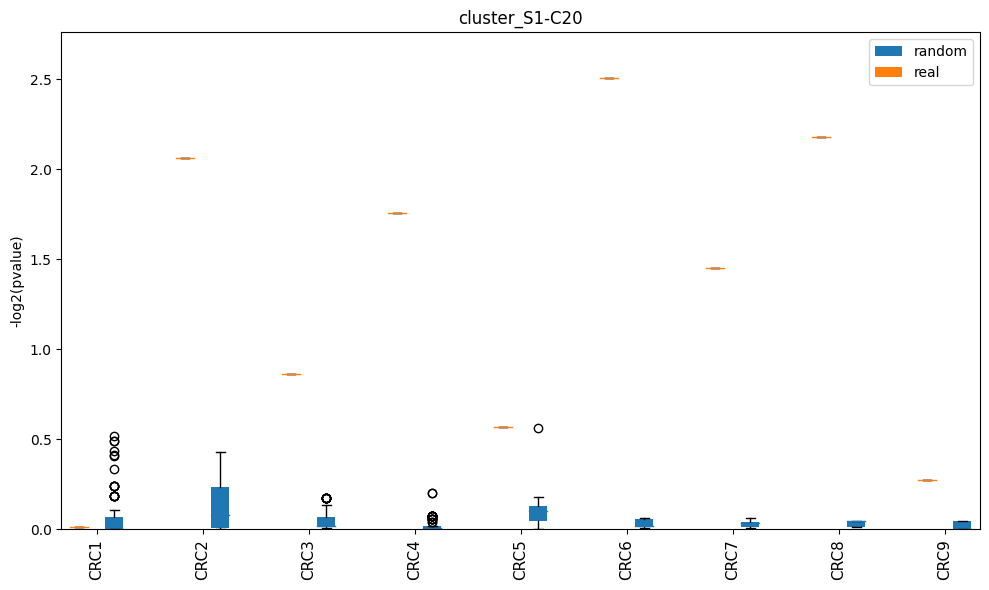

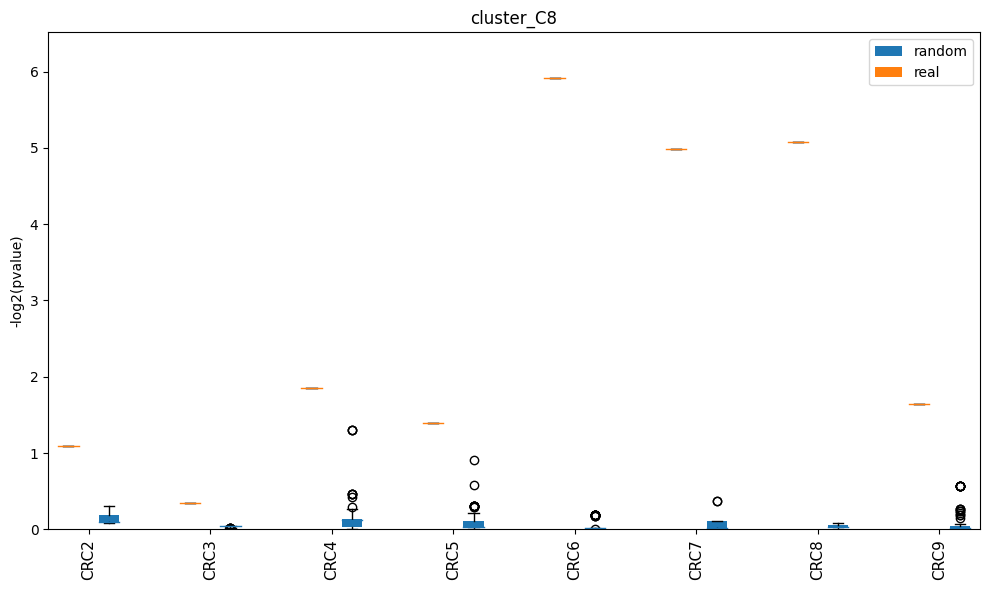

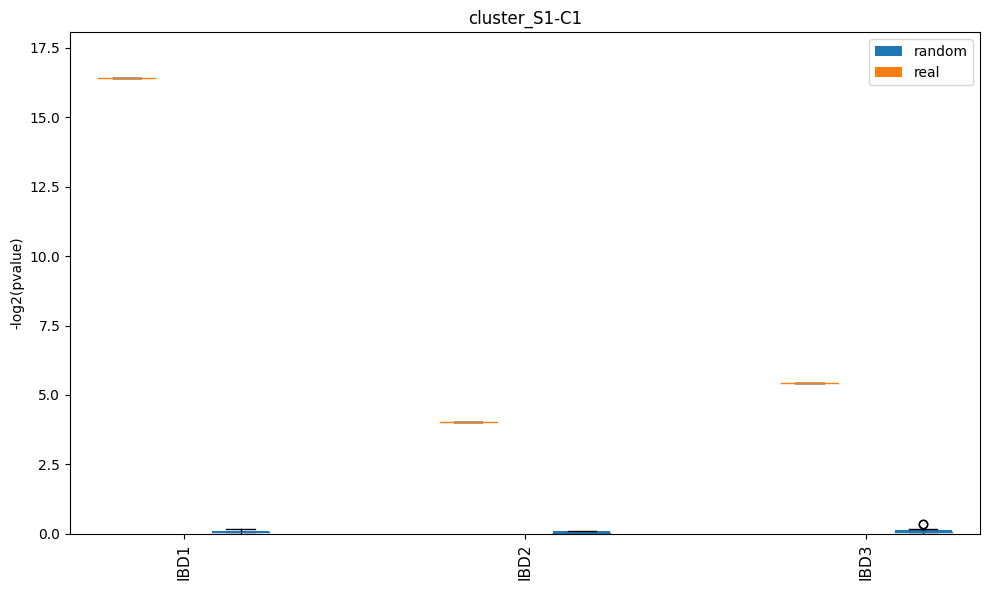

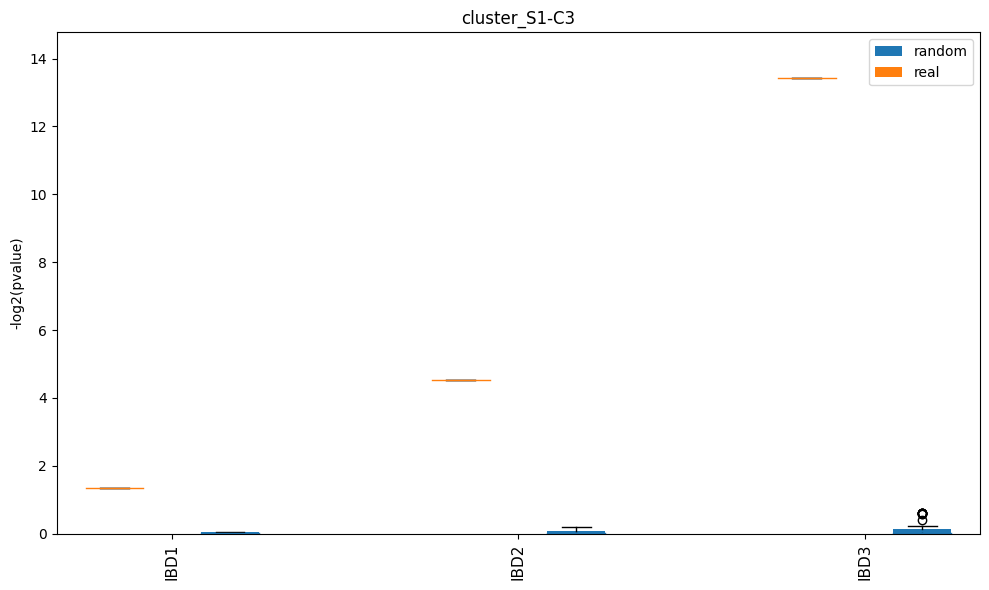

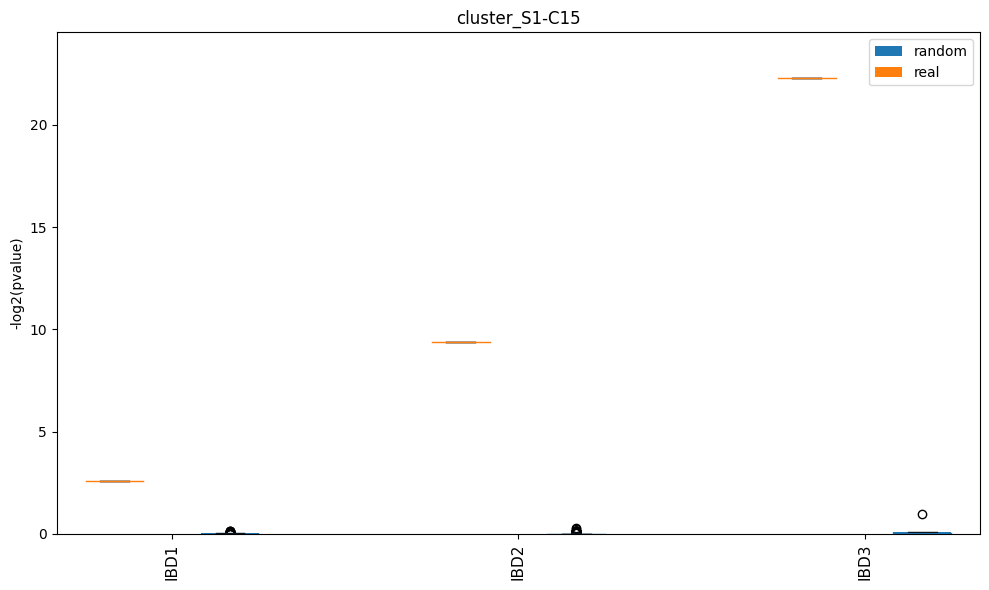

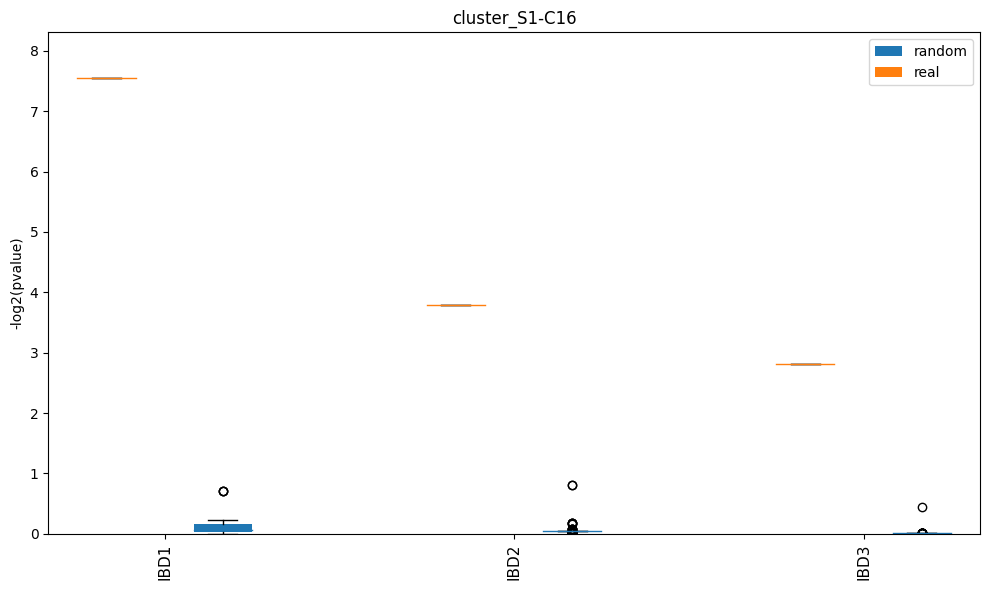

In [9]:
# draw boxplot for each cohort and cluster
import numpy as np
import matplotlib.pyplot as plt
plist = ['CRC', 'IBD']
for pheno in plist:
    data_dir = os.path.join(outer_dir, pheno)
    clusters = select_clusters(diff_df, data_dir)
    for cluster in clusters:
        cohort_simus = []
        cohort_reals = []
        labels = []
        max_y = 0
        tmp_idir = os.path.join(indir, pheno)
        for cohort in os.listdir(tmp_idir):
            if not os.path.isdir(os.path.join(tmp_idir, cohort)):
                continue
            real_path = os.path.join(tmp_idir, cohort, 'SE', 'p_detail.tsv')
            real_pvalues = pd.read_csv(real_path, sep='\t', header=0, index_col=0)
            if pd.isna(real_pvalues.loc[cluster, 'p_adj']):
                continue
            labels.append(cohort)
            outdir = os.path.join(output_dir, pheno, cohort)
            simu_pvalues = pd.read_csv(os.path.join(outdir, 'pvalues.tsv'), sep='\t', header=None, index_col=0)
        # result\GCN_fix_tree\SE\GCN_tree_diff\CRC\CRC1\p_CRC1.tsv
            
            simu_v = [-np.log10(x) for x in list(simu_pvalues.loc[cluster, :])]
            real_v = -np.log10(real_pvalues.loc[cluster, 'p_adj'])
            cohort_simus.append(simu_v)
            cohort_reals.append([real_v])
            max_y = max(max_y, max(simu_v + [real_v]))

        x1 = list(range(1, len(cohort_simus)*3, 3))
        x2 = [x+1 for x in x1]
        plt.figure(figsize=(10, 6))
        box1 = plt.boxplot(cohort_simus,positions=x2, patch_artist=True, 
                    boxprops={"facecolor": "C0",
                            "edgecolor": "C0",
                            "linewidth": 0},
                    medianprops={"color": "C0", "linewidth": 1})
        box2 = plt.boxplot(cohort_reals,positions=x1, patch_artist=True, 
                    boxprops={"facecolor": "C1",
                            "edgecolor": "C1",
                            "linewidth": 0},
                    medianprops={"color": "C1", "linewidth": 1})
        lx = [(x1[i] + x2[i])/2 for i in range(len(x1))]
        plt.ylim([0, max_y*1.1])
        plt.xticks(lx,labels,fontsize=11, rotation=90)
        plt.ylabel('-log2(pvalue)')


        plt.legend(handles=[box1['boxes'][0],box2['boxes'][0]],labels=['random','real'], loc=1)
        plt.title('{}'.format(cluster))
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, pheno, '{}.pdf'.format(cluster)), dpi=300)
        plt.show()
    

    

In [ ]:
# 
print(outpath
      )